In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hydrant.topology.geom as gm
import hydrant.mizuRoute.mizuRoute as mz
import subprocess
import os
from   shapely.geometry import Point

In [2]:
# inputs
path_out = '/home/shg096/scratch/West/domain/'
prefix = 'West_'
regions = ['3'] # 3 North America
riv_path = '/home/shg096/data/HDMA/processed/'
cat_path = '/home/shg096/data/HDMA/processed/'
riv_file_template = 'hdma_global_stream.shp'
cat_file_template = 'hdma_global_catch_v2_*000000.gpkg'

In [3]:
if not os.path.isdir(path_out):
    os.makedirs(path_out)

# Load and append the pfaf

In [5]:
riv, cat = gm.hdma_read_file  (regions,
                               riv_path,
                               riv_file_template,
                               cat_path,
                               cat_file_template)

# prepare the network topology

In [5]:
riv, cat = gm.prepare_ntopo(riv=riv,\
                            riv_cols={'id':'COMID', 'next_id':'NextDownID'},\
                            cat=cat,\
                            cat_cols={'id':'COMID', 'hillslope':'hillslope', 'area' :'unitarea'},\
                            network = 'merit')

/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/hydrant/topology/geom.py:314: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river['latitude'] = cat.centroid.y
/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/hydrant/topology/geom.py:315: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river['longitude'] = cat.centroid.x


# Example-1 From Fraser River

In [7]:
# slice the domain for various stations and their seg ID
cat_slice, riv_slice = gm.subset_ntopo(cat=cat,\
                                       cat_cols={'id':'hruid'},\
                                       riv=riv,\
                                       riv_cols={'id':'seg_id', 'next_id':'Tosegment'},\
                                       outlet_id=[3044523]) # segment that is aimed to make the subbasin for

<AxesSubplot:>

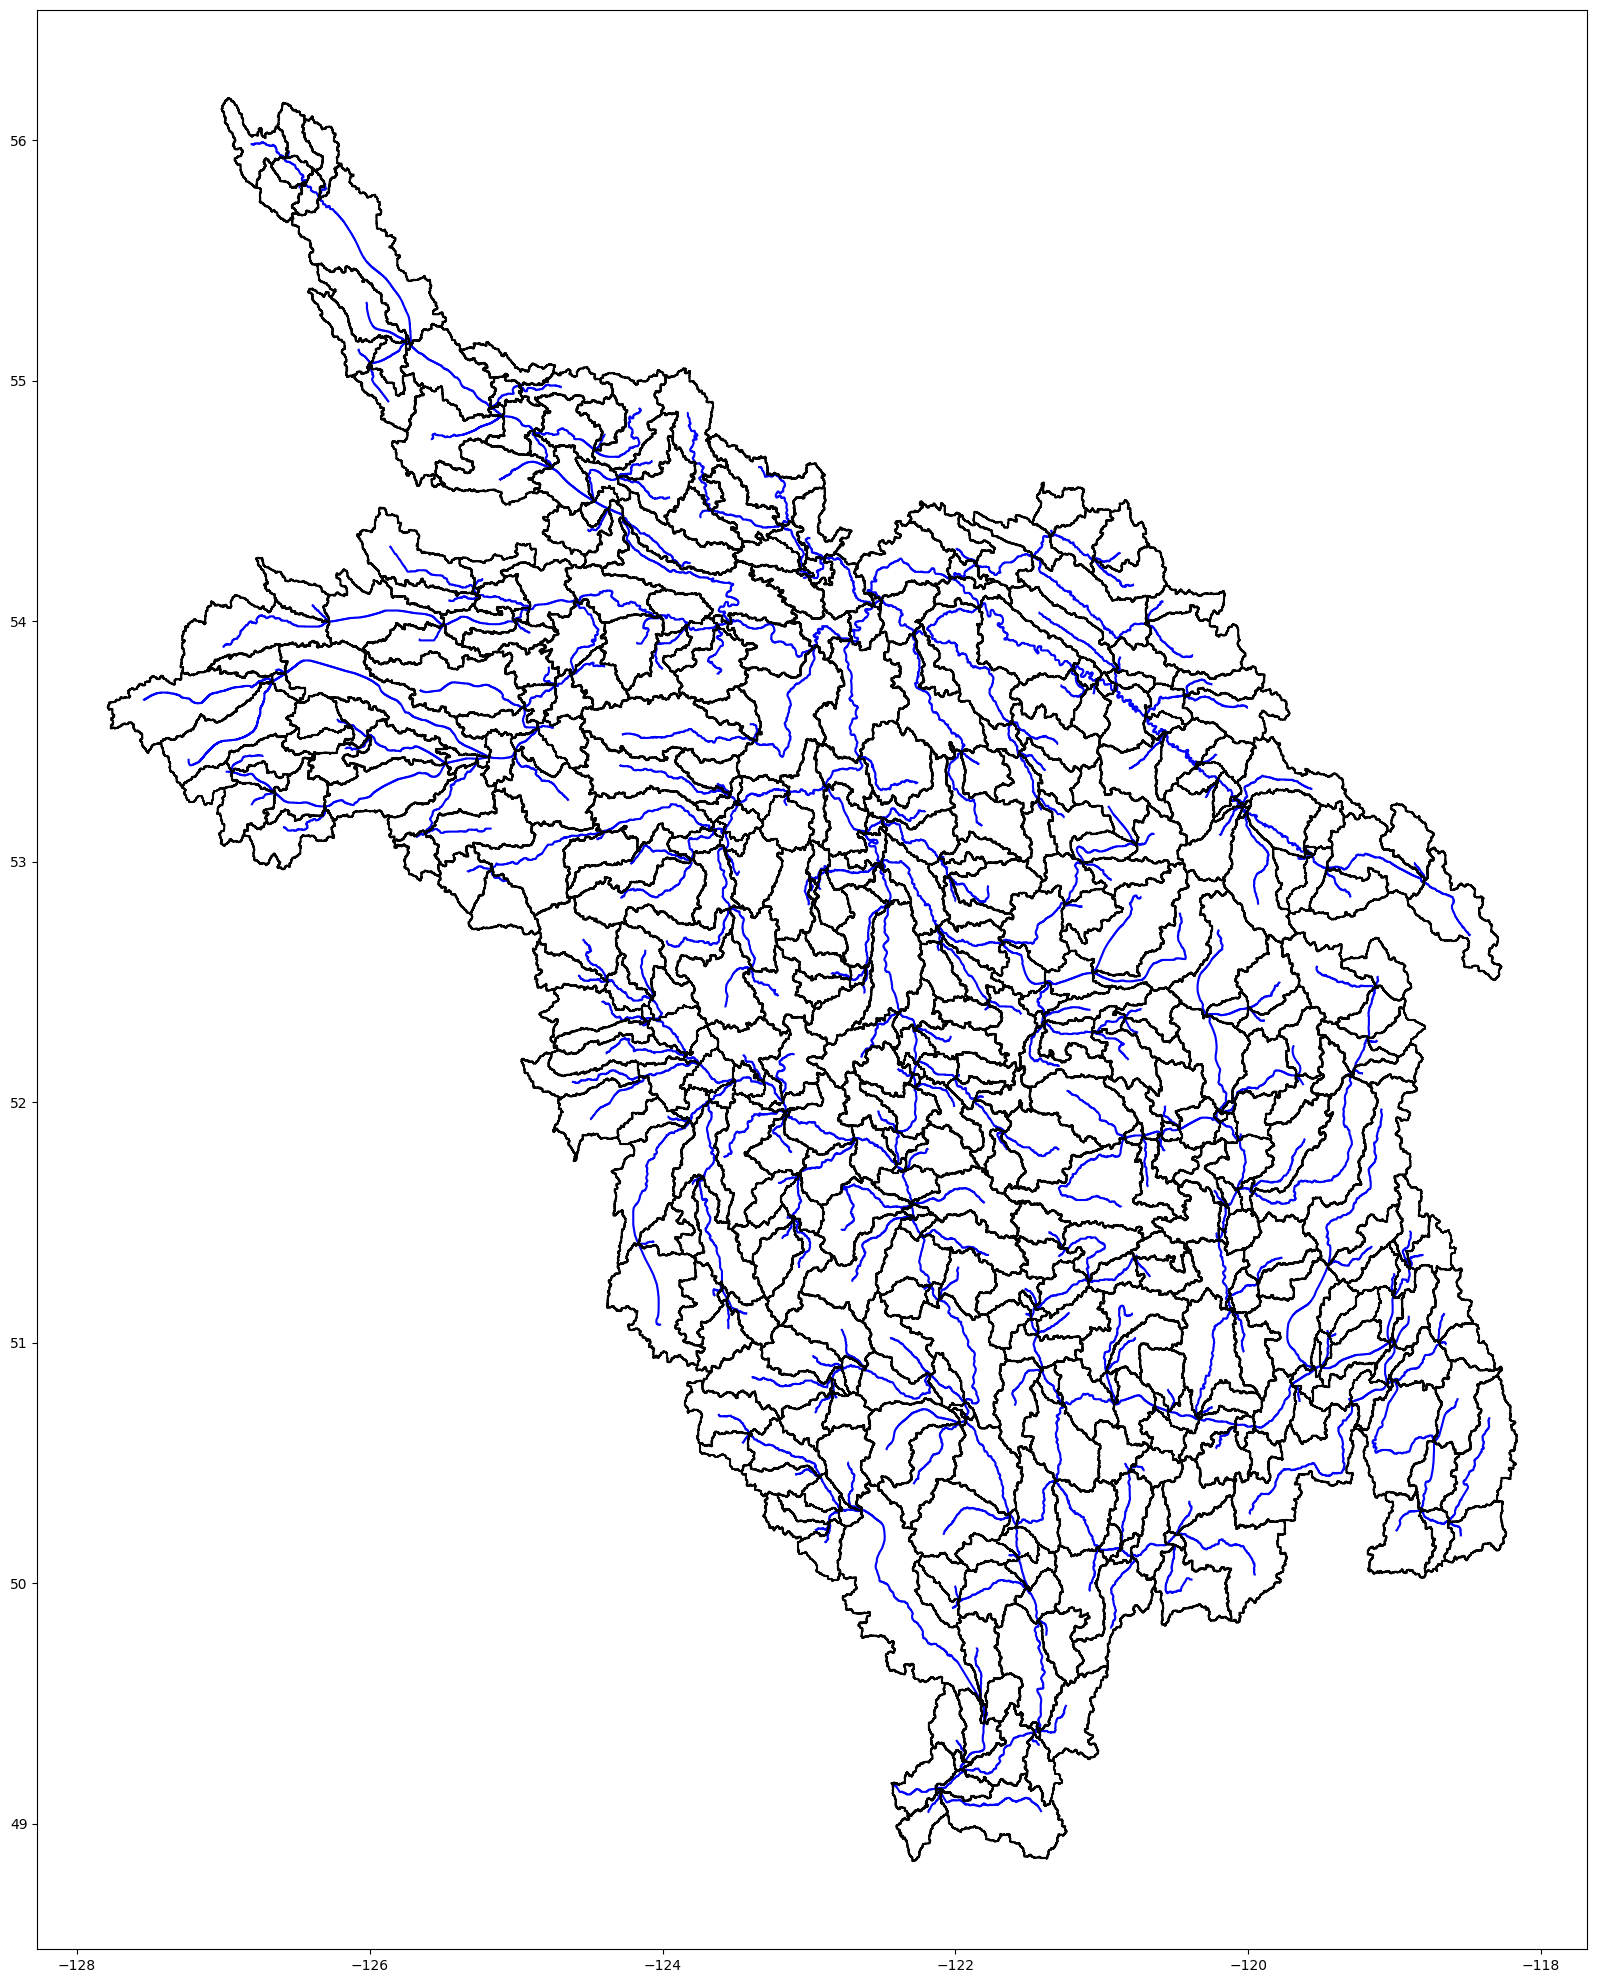

In [8]:
fig, ax = plt.subplots(figsize=(20,30))
riv_slice.plot(ax=ax, color='b')
cat_slice.boundary.plot(ax=ax, color='k')

In [10]:
mz_ntopo = mz.create_nc_ntopo(riv_slice,
                              cat_slice,
                              network = 'hdma')
mz_ntopo

<xarray.Dataset>
Dimensions:     (n: 491)
Coordinates:
  * n           (n) int64 0 1 2 3 4 5 6 7 8 ... 483 484 485 486 487 488 489 490
Data variables: (12/16)
    BotElev     (n) float64 349.0 890.0 730.0 393.0 ... 29.0 10.0 6.0 6.0
    Length      (n) float64 2.271e+03 832.7 4.497e+03 ... 1.817e+04 3.967e+04
    OBJECTID    (n) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    PFAF        (n) object '3142614' '3145364' '3146992' ... '31415' '314133'
    PFAF_CODE   (n) float64 3.143e+11 3.145e+11 ... 3.142e+11 3.141e+11
    PF_TYPE     (n) int64 6 6 6 6 6 7 5 5 5 5 6 6 6 ... 2 2 2 2 2 2 2 2 2 2 2 2
    ...          ...
    end_x       (n) float64 -120.0 -122.7 -119.6 -120.2 ... -121.9 -122.1 -122.4
    end_y       (n) float64 50.65 52.51 53.04 51.47 ... 49.37 49.22 49.15 49.17
    flow_acc    (n) float64 251.2 251.4 253.7 ... 2.199e+05 2.287e+05 2.308e+05
    seg_id      (n) int64 3000119 3000137 3000366 ... 3044492 3044518 3044523
    start_x     (n) float64 -120.0 -122.7 -119.6 -120.1 ... -121.5 -121.9 -122.1
    start_y     (n) float64 50.64 52.51 53.07 51.46 ... 49.4 49.37 49.22 49.15

## save

In [9]:
# cat_slice.to_file(path_out+prefix+'cat.shp')
# riv_slice.to_file(path_out+prefix+'riv.shp')
# mz_ntopo.to_netcdf(path_out+prefix+'mizuRoute_ntopo.nc')


# Example-2 From basins of identified pfafs that intersect with Alberta and Saskatchewan

In [11]:
# load the info and the provience
trg_shp = gpd.read_file('../data/province/provinces.shp')
sel_pr = ['Alberta','Saskatchewan']
# subsetting `provinces` variable
trg_provinces = trg_shp.loc[trg_shp.PRENAME.isin(sel_pr)].copy().to_crs(epsg=4326)

In [12]:
# slice the domain for various stations and their seg ID
cat_slice, riv_slice = gm.subset_ntopo(cat=cat,\
                                       cat_cols={'id':'hruid'},\
                                       riv=riv,\
                                       riv_cols={'id':'seg_id', 'next_id':'Tosegment'},\
                                       shapefile=trg_provinces)

<AxesSubplot:>

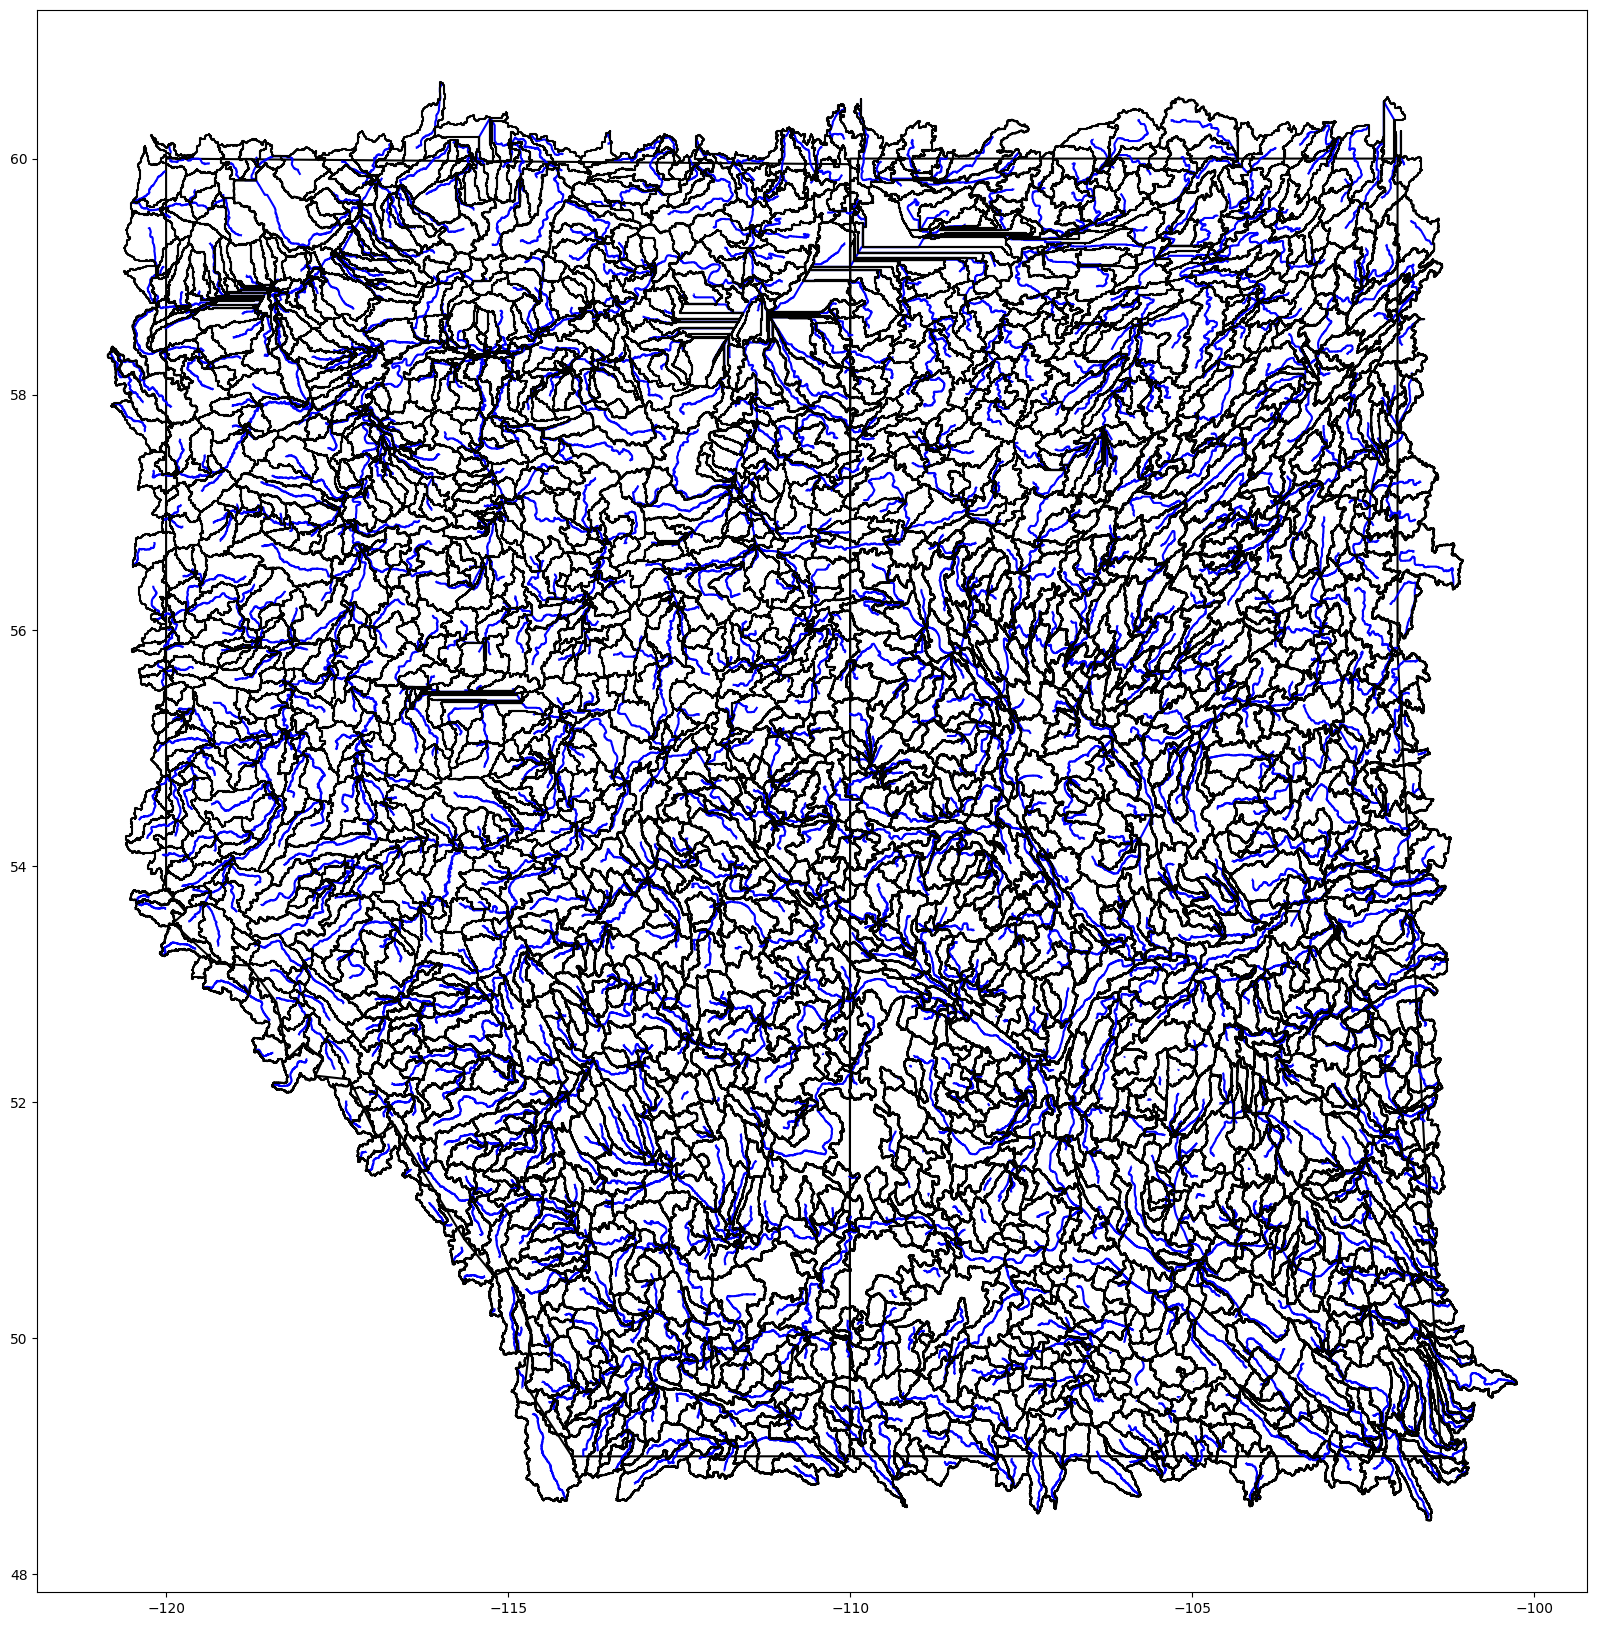

In [13]:
fig, ax = plt.subplots(figsize=(20,30))
trg_provinces.boundary.plot(ax=ax, color='k')
riv_slice.plot(ax=ax, color='b')
cat_slice.boundary.plot(ax=ax, color='k')

In [16]:
mz_ntopo = mz.create_nc_ntopo(riv_slice,
                              cat_slice,
                              network = 'merit')
mz_ntopo

<xarray.Dataset>
Dimensions:     (n: 16117)
Coordinates:
  * n           (n) int64 0 1 2 3 4 5 6 ... 16111 16112 16113 16114 16115 16116
Data variables: (12/20)
    COMID       (n) int64 71000025 71000026 71000027 ... 78014078 78015441
    length      (n) float64 1.72e+04 3.977e+03 1.241e+04 ... 3.672e+04 2.406e+04
    lengthdir   (n) float64 12.68 2.61 8.471 12.41 ... 6.832 25.68 24.16 18.86
    sinuosity   (n) float64 1.356 1.524 1.465 1.372 ... 1.153 1.599 1.52 1.276
    slope       (n) float64 0.0003943 0.0007272 0.0005707 ... 0.01166 0.01014
    uparea      (n) float64 1.959e+10 2.232e+09 ... 2.057e+08 1.465e+08
    ...          ...
    up4         (n) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    hillslope   (n) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    unitarea    (n) float64 53.97 28.63 63.28 46.27 ... 69.44 218.7 205.7 146.5
    latitude    (n) float64 58.96 59.02 59.04 59.05 ... 49.96 49.12 49.05 48.97
    longitude   (n) float64 -102.1 -102.0 -102.1 -102.2 ... -114.3 -114.2 -114.2
    width       (n) float64 141.0 48.25 47.52 39.58 ... 9.333 15.79 15.34 13.11

In [ ]:
# cat_slice.to_file(path_out+prefix+'cat.shp')
# riv_slice.to_file(path_out+prefix+'riv.shp')
# mz_ntopo.to_netcdf(path_out+prefix+'mizuRoute_ntopo.nc')

# Example-3 From basins of identified pfafs that intersect with Alberta

In [18]:
data = {
    'Station ID': ['05BE004', '05BH004', '05BL004', '05CC002'],
    'seg ID': [3035173, 3037796, 3030143, 3039206],
    'Station name': [
        'BOW RIVER NEAR SEEBE',
        'BOW RIVER AT CALGARY',
        'HIGHWOOD RIVER BELOW LITTLE BOW CANAL',
        'RED DEER RIVER AT RED DEER'
    ],
    'up': [0, 0, 0, 0],
    'X': [-115.03,-114.05,-113.86,-113.82],
    'Y': [  51.11,  51.05,  50.58,  52.27]
}

# Create a DataFrame from the dictionary
stations_seg_id = pd.DataFrame(data)

# Create a points from the dictionary
geometry = [Point(xy) for xy in zip(data['X'], data['Y'])]
stations_points = gpd.GeoDataFrame(data, geometry=geometry, crs='EPSG:4326')

In [19]:
# slice the domain for various stations and their seg ID
cat_slice, riv_slice = gm.subset_ntopo(cat=cat,\
                                       cat_cols={'id':'hruid'},\
                                       riv=riv,\
                                       riv_cols={'id':'seg_id', 'next_id':'Tosegment'},\
                                       outlet_id=list(stations_seg_id['seg ID']))



<AxesSubplot:>

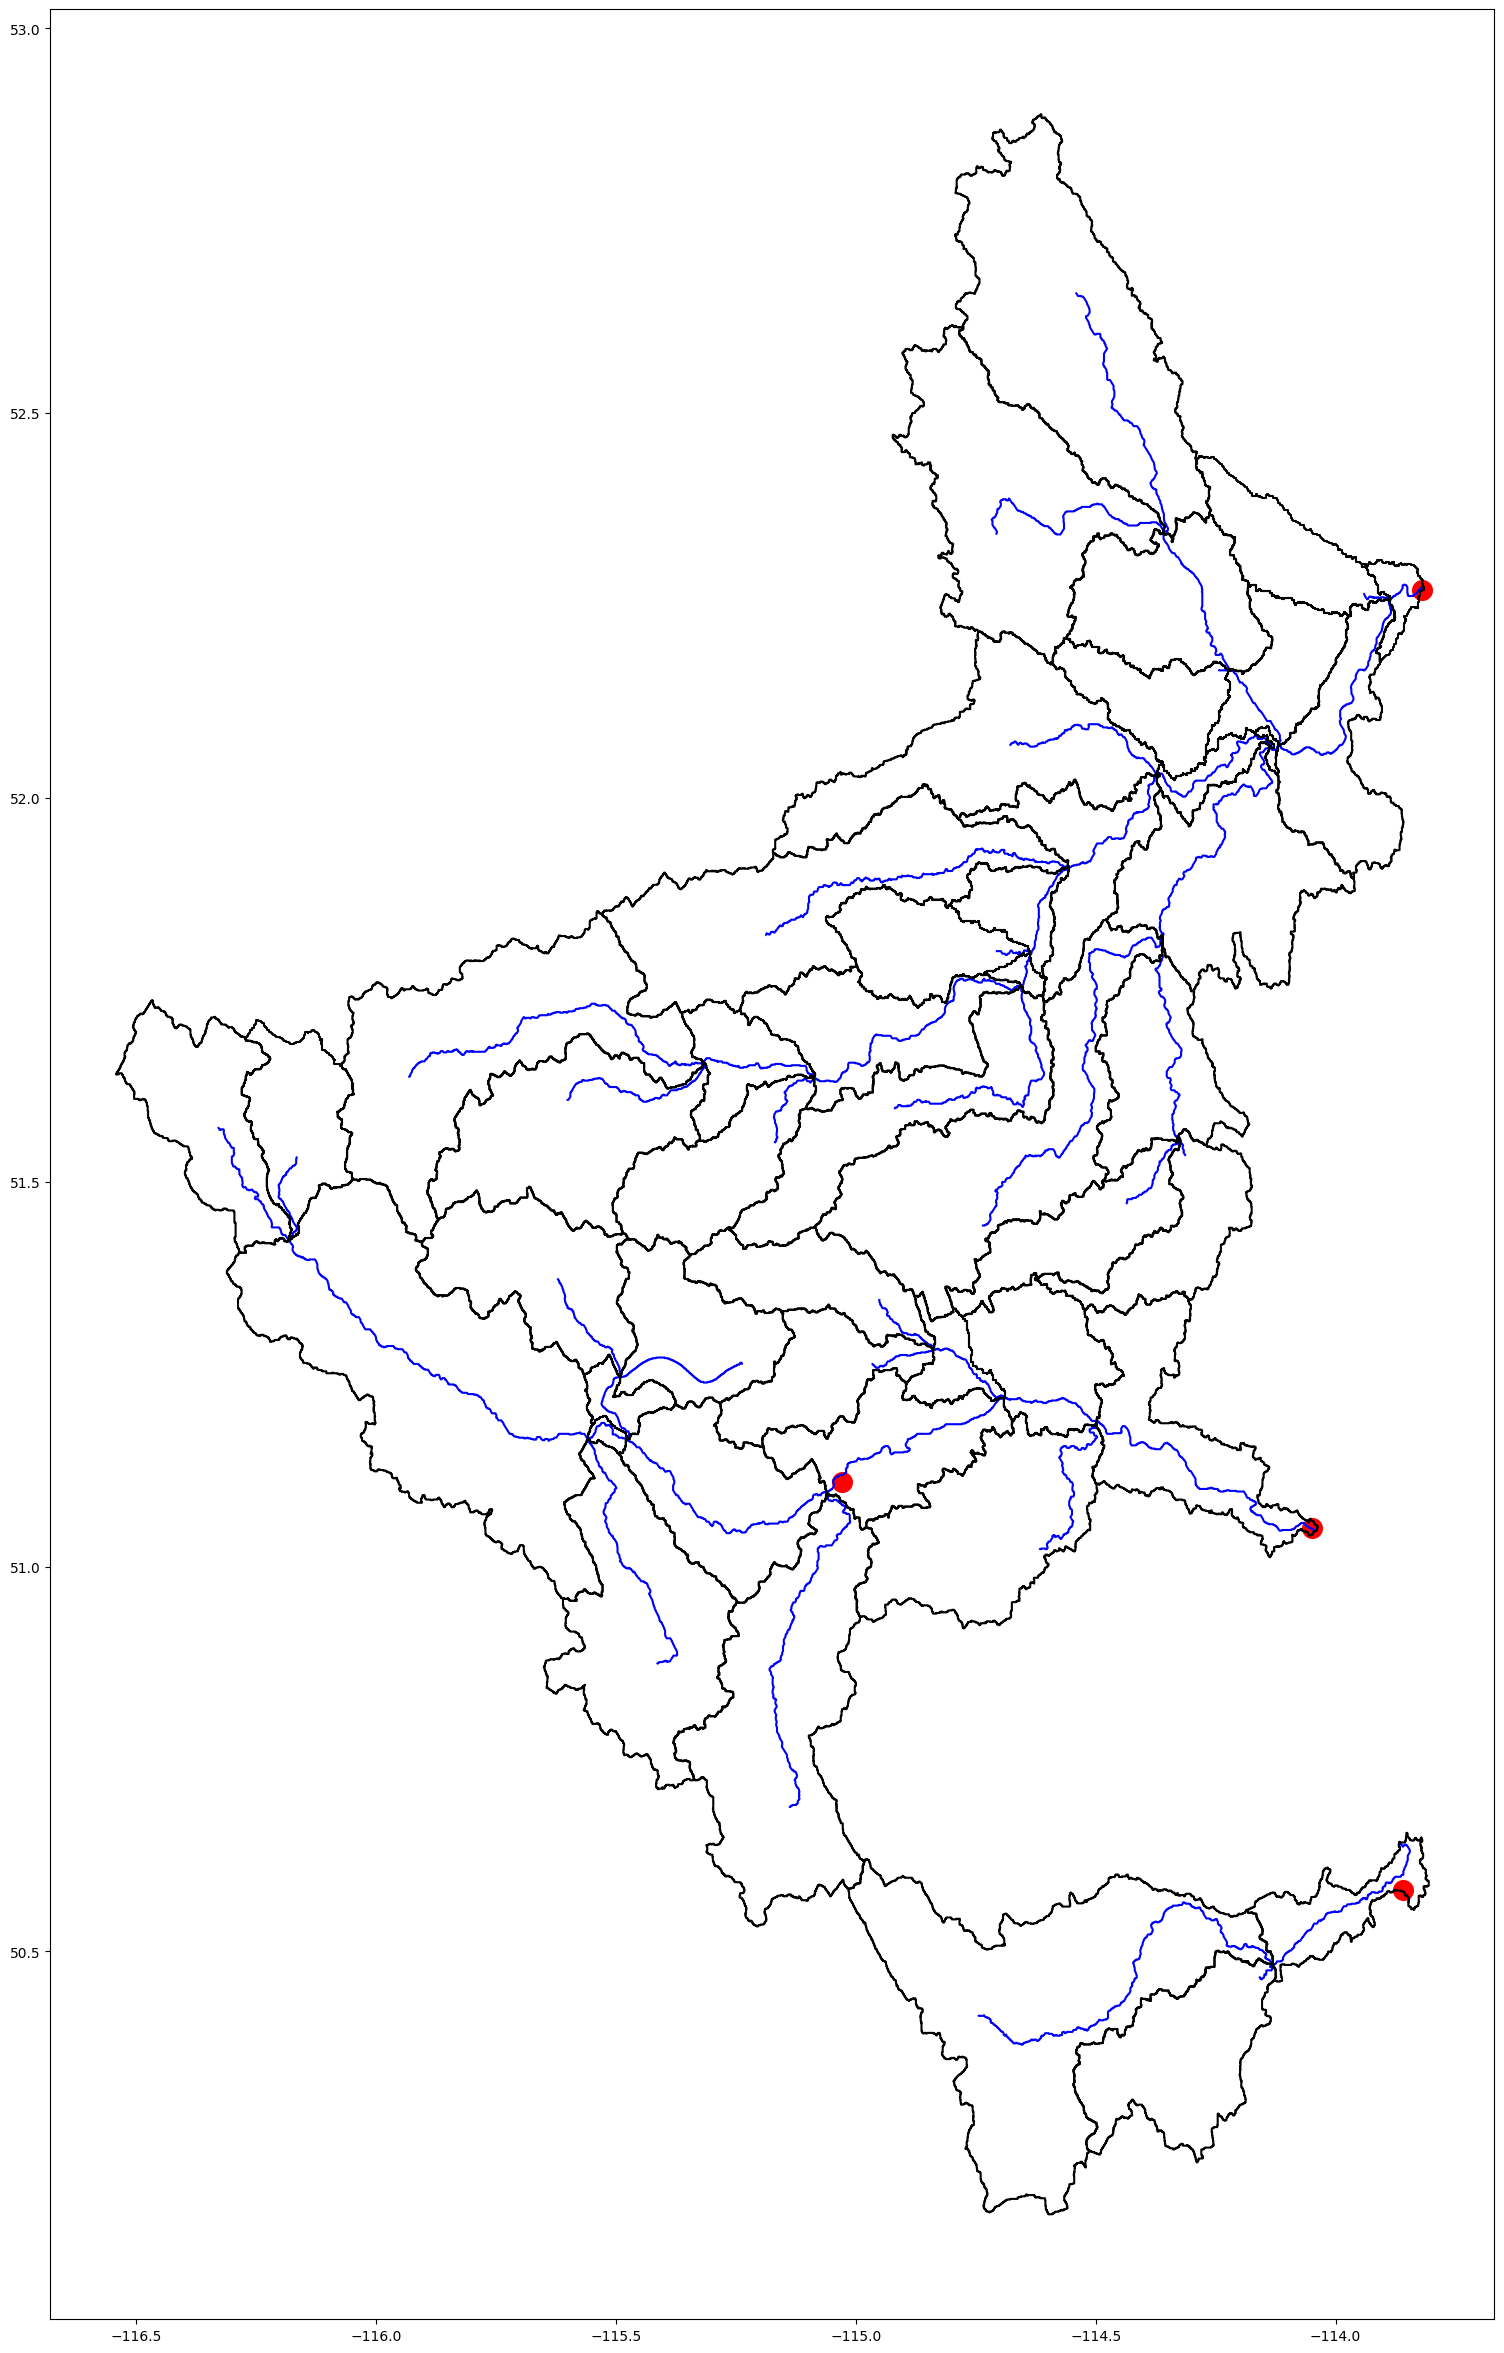

In [20]:
fig, ax = plt.subplots(figsize=(20,30))
riv_slice.plot(ax=ax, color='b')
cat_slice.boundary.plot(ax=ax, color='k')
stations_points.plot(ax=ax, color='r', markersize=200)


In [22]:
mz_ntopo = mz.create_nc_ntopo(riv_slice,
                              cat_slice,
                              network = 'hdma')
mz_ntopo

<xarray.Dataset>
Dimensions:     (n: 47)
Coordinates:
  * n           (n) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45 46
Data variables: (12/16)
    BotElev     (n) float64 903.0 857.0 1.09e+03 1.065e+03 ... 891.0 857.0 849.0
    Length      (n) float64 2.229e+03 7.085e+03 ... 4.416e+04 9.113e+03
    OBJECTID    (n) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    PFAF        (n) object '342662' '3426594' '3426952' ... '3426595' '3426593'
    PFAF_CODE   (n) float64 3.427e+11 3.427e+11 ... 3.427e+11 3.427e+11
    PF_TYPE     (n) int64 5 6 6 5 6 6 5 4 6 6 3 5 5 ... 3 3 3 3 3 3 3 3 3 3 3 3
    ...          ...
    end_x       (n) float64 -114.2 -113.9 -114.6 -114.3 ... -114.1 -113.9 -113.8
    end_y       (n) float64 52.17 52.26 51.8 51.56 ... 51.05 52.07 52.26 52.28
    flow_acc    (n) float64 251.9 257.0 288.0 ... 8.239e+03 1.148e+04 1.179e+04
    seg_id      (n) int64 3000185 3000687 3003294 ... 3037917 3039109 3039206
    start_x     (n) float64 -114.2 -113.9 -114.7 -114.3 ... -114.1 -114.1 -113.9
    start_y     (n) float64 52.17 52.27 51.8 51.53 ... 51.19 52.06 52.07 52.26

In [ ]:
# cat_slice.to_file(path_out+prefix+'cat.shp')
# riv_slice.to_file(path_out+prefix+'riv.shp')
# mz_ntopo.to_netcdf(path_out+prefix+'mizuRoute_ntopo.nc')